# TSNE
<img src="https://lvdmaaten.github.io/tsne/examples/coil_tsne.jpg" alt="COIL Data" style="width: 500px;"/>

                                                COIL Data Visualization with TSNE

TSNE is a wonderful and surprisingly effective dimensionality reduction algorithm that finds information in high dimensional data through minimising the Kullback Leiback Divergence between the probabilities in the full data space and the reduced space.

In the original high dimensional space, each point's probability of occurence are:

$$ P_{j|i} = \frac{exp(-||x_i - x_j||^2 / 2 \sigma_i^2)}{\sum exp(-||x_i - x_k||^2 / 2 \sigma_i^2)} $$

In the lower embedding space, each point's probability is:

$$ Q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum (1 + ||y_k - y_l||^2)^{-1}} $$

We want to minimise the KL Divergence between $ P_{ij} $ and $ Q_{ij} $ so:

$$ J(Y) = KL(P || Q) = \sum p_{ij} log(\frac{p_{ij}}{q_{ij}}) $$

By splitting the gradient updates to attractive and repulsive forces we get the gradient updates:

$$ \frac{dJ}{dy_i} = F_{attract_i} - Z F_{repel_i} $$

$$ F_{attract_i} = \sum p_{ij} q_{ij} Z (y_i - y_j) $$

$$ F_{repel_i} = \sum q_{ij}^2 Z (y_i - y_j) $$

cuML TSNE applies some cool optimizations to calculate both $ F_{attract_i} $ and $ F_{repel_i} $, which are described at the very bottom of this notebook!

In [1]:
from cuml.manifold import TSNE as cuml_TSNE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cuml_tsne = cuml_TSNE(n_components = 2)
cuml_tsne

TSNE(n_components=2, perplexity=31.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1.0000000116860974e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5, learning_rate_method='adaptive', n_neighbors=90, perplexity_max_iter=100, exaggeration_iter=250, pre_momentum=0.5, post_momentum=0.800000011920929, handle=<cuml.common.handle.Handle object at 0x7fb39151af48>)

In [4]:
from sklearn.manifold import TSNE
sklearn_tsne = TSNE()
sklearn_tsne

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=0)

# MNIST digits
MNIST is the "dataset of all datasets", where all algorithms should be tested on! TSNE does surprisingly well on MNIST, showcasing how each digit has been separated into noticeable clusters.

Notice - TSNE was given no information on which digits belong to which class!!! Clearly TSNE has clustered the data into well defined structure.

In [5]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X = x_train.reshape((60000,28**2)).astype(np.float32)
y = y_train

Let's check out some of the digits!

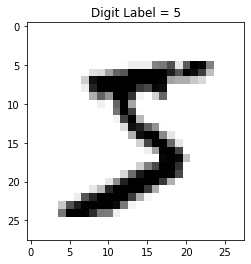

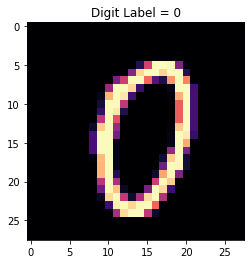

In [6]:
plt.imshow(X[0].reshape(28, 28), cmap = 'binary')
plt.title('Digit Label = {}'.format(y[0]))
plt.show()
plt.imshow(X[1000].reshape(28, 28), cmap = 'magma')
plt.title('Digit Label = {}'.format(y[1000]))
plt.show()

Let's now apply TSNE and see the result!

CPU times: user 2.26 s, sys: 996 ms, total: 3.25 s
Wall time: 3.25 s


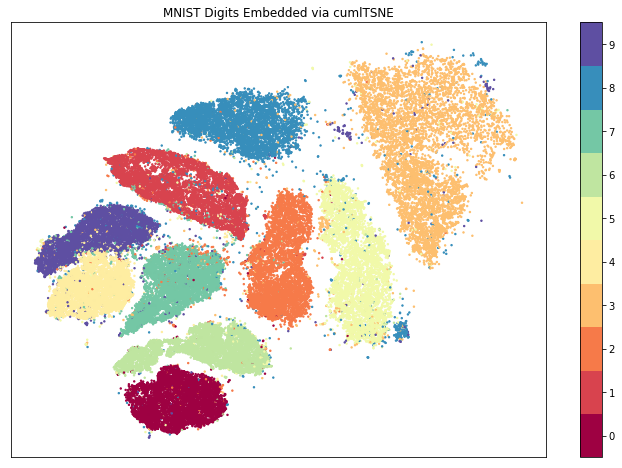

In [7]:
%time Y = cuml_tsne.fit_transform(X)

fig, ax = plt.subplots(1, figsize = (12, 8))
plt.scatter(Y[:,1], Y[:,0], s = 2, c = y, cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title('MNIST Digits Embedded via cumlTSNE')
plt.show()

We also try using Sklearn. You might have to wait a while...

You can see on n = 60,000, cuML's TSNE manages to finish in roughly 3.3 **SECONDS**, whilst Sklearn takes an unfortunately long amount of time (1 **HOURS** and 15 minutes). To make you not have to impatient, we subsampled a small 1000 points...

Even on a small 1000 points, Sklearn takes roughly 6.5 seconds....

Using the speedup formula of $ Speedup = \frac{Old Time}{New Time}$

cuML's speedup is:

In [8]:
speedup = 75 / (3.3 / 60)  # 75 minutes / (3.3/60) minutes

print("CuML Speedup is = {}".format(speedup))

CuML Speedup is = 1363.6363636363637


CPU times: user 6.92 s, sys: 0 ns, total: 6.92 s
Wall time: 6.9 s


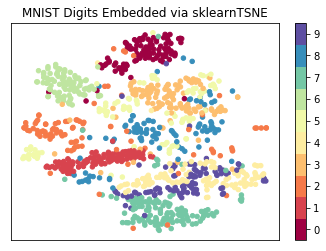

In [9]:
rand = np.random.choice(X.shape[0], size = 1000, replace = 0)
%time Y = sklearn_tsne.fit_transform(X[rand])

fig, ax = plt.subplots(1, figsize = (6, 4))
plt.scatter(Y[:,1], Y[:,0], s = 20, c = y[rand], cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title('MNIST Digits Embedded via sklearnTSNE')
plt.show()

# Fashion MNIST
Another popular dataset is Fashion MNIST. Instead of having 10 classes of digits, Fashion MNIST has 10 classes as listed below:

In [10]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X = x_train.reshape((60000,28**2)).astype(np.float32)
y = y_train

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

Let's showcase some of the data in Fashion MNIST!

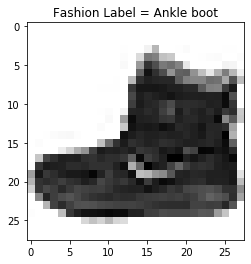

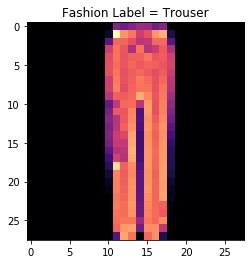

In [11]:
plt.imshow(X[0].reshape(28, 28), cmap = 'binary')
plt.title('Fashion Label = {}'.format(classes[y[0]]))
plt.show()
plt.imshow(X[1000].reshape(28, 28), cmap = 'magma')
plt.title('Fashion Label = {}'.format(classes[y[1000]]))
plt.show()

Now let's use TSNE to reduce the dimensions to 2!

CPU times: user 2.07 s, sys: 1.01 s, total: 3.08 s
Wall time: 3.07 s


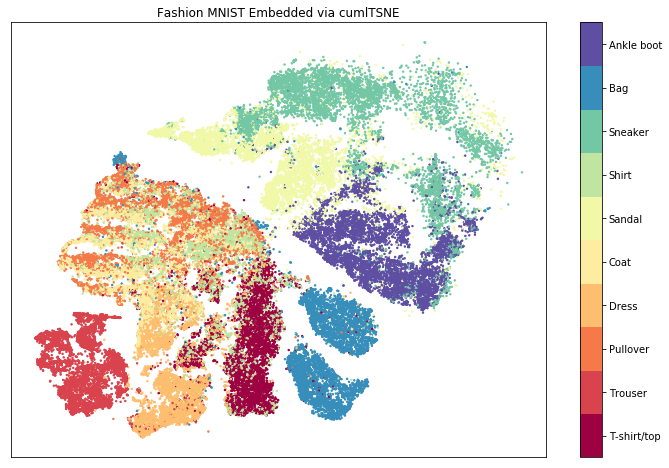

In [12]:
%time Y = cuml_tsne.fit_transform(X)

fig, ax = plt.subplots(1, figsize = (12, 8))
plt.scatter(Y[:,1], Y[:,0], s = 2, c = y, cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlTSNE');

# Breast Cancer Data
Let's inject some humanity into the TSNE algorithm! We shall help predict if a patient might develop cancer using TSNE!

A malignant tumour is one that aggressively grows, and must be removed immediately. A benign tumour stays on the patient, but isn't aggressive. You can see below TSNE has been able to separate the benign and malignant tumours pretty well.

CPU times: user 788 ms, sys: 192 ms, total: 980 ms
Wall time: 979 ms


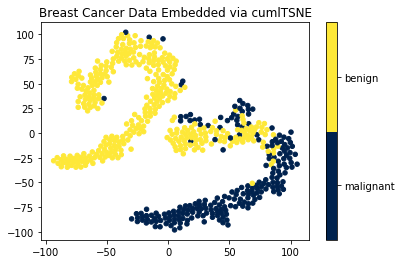

In [13]:
from sklearn.datasets import load_breast_cancer as data
X, y = data().data, data().target
classes = data().target_names

%time Y = cuml_tsne.fit_transform(X)
plt.scatter(Y[:,0], Y[:,1], c = y, s = 20, cmap = 'cividis')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(3)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(classes)
plt.title('Breast Cancer Data Embedded via cumlTSNE');

# Boston Housing Prices Data
Clearly TSNE doesn't just have to applied on classification data! We can use TSNE to visualize the structure of regressive data!

We can see how housing price differences can be separated with TSNE.

CPU times: user 768 ms, sys: 196 ms, total: 964 ms
Wall time: 964 ms


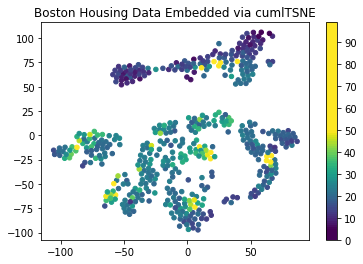

In [14]:
from sklearn.datasets import load_boston as data
X, y = data().data, data().target

%time Y = cuml_tsne.fit_transform(X)
plt.scatter(Y[:,0], Y[:,1], c = y, s = 20, cmap = 'viridis')
plt.setp(ax, xticks = [], yticks = [])
plt.colorbar(boundaries = np.arange(100))
plt.title('Boston Housing Data Embedded via cumlTSNE');

# TSNE cuML Optimizations
---
How does one optimize the below cost function for TSNE?
$$ \frac{dJ}{dy_i} = F_{attract_i} - Z F_{repel_i} $$

---
## Attractive Forces Optimizations
---

$$ F_{attract_i} = \sum p_{ij} q_{ij} Z (y_i - y_j) $$

First, we can see that a brute force approach to calculate $ F_{attract_i} $ will take $O(n^2)$ time. However, as noted by Maaten in "Barnes-Hut-SNE 2013 https://arxiv.org/abs/1301.3342", we can reduce this to $O(uN)$ time, where u is usually $u = 3*perplexity$.

Instead of calculating the full attractive forces between all N points, we perform a K Nearest Neighbor Search with neighbors = 3 * perplexity (usaully 3 * 30). This allows the attractive forces to be reduced to approx $O(90*N) = O(N)$ time.

Maaten notes a reduction in accuracy of a small 0.5% or so.

However, in cuML TSNE, we have provided even more speedups.


### (1) Use (yi - yj) and COO sparse matrices

In CannyLab's paper "t-SNE-CUDA: GPU-Accelerated t-SNE and its Applications to Modern Data" [https://arxiv.org/pdf/1807.11824.pdf], they calculated PQ separately hence allowing the attractive forces to eat up a large proportion of time of the algorithm (in fact they showcased that the attractive forces took 70% of TSNE's time).

cuML managed to make it eat up only 20 - 30% of TSNE's time, whereby 50% was spent finding the nearest neighbors using FAISS on n = 600,000. We show that instead of doing using 2 cuSPARSE operations:

$$ PQ = p_{ij} \sum (1 + ||y_i - y_j||)^{-1} $$
$$ F_{attract_i} = PQ y_i - PQ y_j $$

fuse the above and use 1 kernel invocation to calculate:
$$ F_{attract_i} = PQ( y_i - y_j) $$


### (2) Remove Z and broadcast along rows
It has been noted clearly in Maaten's 2013 [https://arxiv.org/pdf/1301.3342.pdf] paper that $ q_{ij} Z = (1 + ||y_i - y_j||)^{-1} $. This allows us to write

$$ F_{attract_i} = \sum p_{ij} (1 + ||y_i - y_j||)^{-1} (y_i - y_j) $$

Likewise, another cool realization is that we can calculate $ p_{ij} (1 + ||y_i - y_j||)^{-1} $ once for each row. Notice that for each datapoint $ p_{i,0} = p_{i,1} = p_{ij}$, since distances are preserved along each row. This allows us to calculate instead:

$$ factor_i = p_{ij} \sum (1 + ||y_i - y_j||)^{-1} $$
$$ F_{attract_{i,0}} = factor_i (y_i - y_0) $$
$$ F_{attract_{i,1}} = factor_i (y_i - y_1) $$

and not:

$$ F_{attract_i} = PQ( y_i - y_j) $$

Likewise using COO matrices instead of CSR sparse matrices allows one to fully maximally use all GPU threads, as each thread can calculate each NNZ in parallel.

### (3) Don't store PQ
Due to (2), we don't ever have to pre-compute PQ, and store it as a separate matrix. This saves more time and memory.


---
## Repulsive Forces Optimizations
---

$$ F_{repel_i} = \sum q_{ij}^2 Z (y_i - y_j) $$

Clearly using the fast Barnes Hut approximation allows us to make TSNE have a $ O(n logn) $ running time, and not a slow $ O(n^2) $ time. We follow Canny Lab's original formulation:

$$ \frac{N_{cell}(y_i - y_{cell})}{(1 + ||y_i - y_{cell}||^2)^2} \approx \sum q_{ij}^2 Z^2 (y_i - y_j) $$

However, one can optimize code sections and kernels using the following tricks:

### (1) Use const, restrict, few volatiles

It has been shown using restrict and const together with as few volatiles as possible allows the compiler to optimize loads and stores dramatically [https://devblogs.nvidia.com/cuda-pro-tip-optimize-pointer-aliasing/].

In fact, a **2x** or more speedup is seen. Using volatile is also discouraged, and we have carefully purged as many volatiles as possible in our code.

### (2) Use kernel invocations as much as possible.

By executing a kernel, it has been shown that we must utilize the kernel as much as possible.

Instead of separating performing:

$$Norm[i] = Z_i - 1$$
$$Z = \sum Norm[i]$$

One can easily use CUDA's atomicAdd operation, and bypass a separate call. So in the repulsive kernel do:

$$Z = Z + Z_i - 1$$


---
## Symmetrization for Perplexities
---
In Maaten's 2013 paper, it has been shown that instead of computing

$$ P_{i|j} = \frac{exp(-||x_i - x_j||^2 / 2 \sigma_i^2)}{\sum exp(-||x_i - x_k||^2 / 2 \sigma_i^2)} $$

One can symmetrize the conditional and compute:

$$ P_{ij} = \frac{P_{i|j} + P_{j|i}}{2n} $$

Clearly this means forming $P_{i|j}$ which is $(N, uN)$ in size, then performing a transpose add operation.

$$P_{ij} = \frac{P_{i|j} + P_{i|j}^T}{2n} $$

To do this, we imploy the following memory efficient and fast algorithm, allowing it to literally run seamlessly in under 17 milliseconds, or taking literally 0% of TSNE's time. Likewise, a dramatic reduction in memory is seen.

The original algorithm is as follows:

---

(1) Use FAISS to get nearest neighbors. This provides $distances(n, k)$ and $indices(n, k)$ **[2nk peak memory]**

(2) Search for the best bandwith using only $distances(n, k)$ and edit in place. **[2nk peak memory]**

(3) Convert $distances(n, k)$ to COO layout. **[5nk peak memory]** then free  $distances(n, k)$ and $indices(n, k)$ **[3nk peak memory]**

(4) Allocate PT COO matrix space then add P + PT (Canny Lab's method). **[12nk peak memory]**

(5) Free COO matrix. **[6nk peak memory]**

---

**However in cuML, we propose the following:**

(1) Use FAISS to get nearest neighbors. This provides $distances(n, k)$ and $indices(n, k)$ **[2nk peak memory]**

(2) Search for the best bandwith using only $distances(n, k)$ and edit in place. **[2nk peak memory]**

(3) ~~Convert distances(n, k) to COO layout. **[5nk peak memory]** then free distances(n, k) and indices(n, k) **[3nk peak memory]**~~ Find the maximum space needed in each row (CSR layout). **[2nk + n peak memory]**

(4) ~~Allocate PT COO matrix space then add P + PT (Canny Lab's method). **[12nk peak memory]**.~~  Allocate space for P + PT then perform P + PT using a symmetrization kernel. **[8nk peak memory]**

(5) ~~Free COO matrix. **[3nk peak memory]**~~ Free $distances(n, k)$ and $indices(n, k)$ **[6nk peak memory]**


#### This means our TSNE implementation uses 4nk less peak memory. This allows us to fit larger datasets + makes our symmetrization method use up to 0% of TSNE's running time :)

---

## Adaptive Parameter Settings
---
It has been shown in "https://github.com/CannyLab/tsne-cuda/issues/42" that TSNE is very sensitive to learning rates and n_neighbors. To combat this problem, we have shown that as n->inf, we must increase the learning rate, decrease the n_neighbors used in the nearest neighbor search and increase early exaggeration.

We use the following adaptive method:

$$ Nneighors = max(102 - 0.0012n, 30)$$
$$ LearningRate = \frac{n}{3} $$
$$ Exaggeration = 24 $$